**Table of contents**<a id='toc0_'></a>    
- [Programming question](#toc1_)    
  - [Imports and Loading the Dataset](#toc1_1_)    
  - [Preprocessing and Feature Selection](#toc1_2_)    
    - [Are there missing values that require imputing?](#toc1_2_1_)    
    - [Is encoding required?](#toc1_2_2_)    
    - [Preprocessing and Feature Selection pipeline](#toc1_2_3_)    
  - [Evaluating Base model performance and preprocessing pipeline](#toc1_3_)    
  - [Hyperparameter Exploration](#toc1_4_)    
    - [Exploring C and Kernels](#toc1_4_1_)    
    - [Exploring class weights and shrinking](#toc1_4_2_)    
    - [Exploring Gamma](#toc1_4_3_)    
  - [Evaluating the Chosen Model's Performance](#toc1_5_)    
  - [Conclusion](#toc1_6_)    
- [Markdown Question](#toc2_)    
  - [Answer](#toc2_1_)    


# <a id='toc1_'></a>[Programming question](#toc0_)

_Write a Python program to pre-process and transform the dataset into a format suitable for developing machine learning models. Use pearson correlation method to identify **ten** most important features. Use these features to build a SVM classifier and evaluate your model’s performance._

## <a id='toc1_1_'></a>[Imports and Loading the Dataset](#toc0_)

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, ParameterGrid

In [4]:
def load_dataset() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Uses np.load to load the training and test datasets used for the models in these notebooks.

    Returns:
        tuple: A tuple containing four numpy arrays representing the training and test datasets.
               The tuple elements are as follows:
               - features_train: A numpy array containing the features of the training dataset.
               - targets_train: A numpy array containing the target labels of the training dataset.
               - features_test: A numpy array containing the features of the test dataset.
               - targets_test: A numpy array containing the target labels of the test dataset.
    """    
    # Train datasets
    features_train = np.load("x_train.npy")
    targets_train = np.load("y_train.npy")
    # Test datasets
    features_test = np.load("x_test.npy")
    targets_test = np.load("y_test.npy")
    return features_train, targets_train, features_test, targets_test

In [5]:
features_train, targets_train, features_test, targets_test = load_dataset()
np.shape(features_train), np.shape(features_test), len(np.unique(targets_test))

((16200, 512), (5400, 512), 10)

In [6]:
features_train

array([[0.46573916, 0.        , 0.        , ..., 0.15444896, 0.02761412,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.42438483, 0.08174433,
        0.0502976 ],
       [0.15436319, 0.01907348, 0.02712335, ..., 0.        , 0.08633541,
        0.        ],
       ...,
       [0.        , 0.22086209, 0.07728773, ..., 0.11481228, 0.1169597 ,
        0.        ],
       [0.        , 0.        , 0.15300888, ..., 0.        , 0.04044536,
        0.00111793],
       [0.0839657 , 0.        , 0.        , ..., 0.00469289, 0.13740638,
        0.        ]])

## <a id='toc1_2_'></a>[Preprocessing and Feature Selection](#toc0_)

Inspecting if the following pre-processing steps are necessary:
* Imputing of missing dta
* Encoding values 
 


### <a id='toc1_2_1_'></a>[Are there missing values that require imputing?](#toc0_)

In [7]:
np.unique(np.sum(np.isnan(features_train), axis=0))

array([0])

In [8]:
np.unique(np.sum(np.isnan(features_test), axis=0))

array([0])

No. therefore, imputing will not be used during preprocessing.

### <a id='toc1_2_2_'></a>[Is encoding required?](#toc0_)

In [9]:
features_train.dtype

dtype('float64')

In [10]:
features_test.dtype

dtype('float64')

No - all values are floats. Encoding is not needed.

### <a id='toc1_2_3_'></a>[Preprocessing and Feature Selection pipeline](#toc0_)

* Features will be scaled. Using minmaxscaler all features will be converted to a range of values (0,1)
* Using Person Correlation Coefficient, the 10 most important features will be kept.
  * This metric estimates the importance of a feature. Therefore the features determined as the most relevant for classifying will be kept.

In [11]:
preprocess_pipeline = Pipeline(steps = [
    ('scaler', MinMaxScaler(feature_range=(0, 1))),  # Scale features between 0 and 1
    ('selectKbest', SelectKBest(r_regression, k=10))  # Selecting top 10 features
    ]) 

In [12]:
features_train = preprocess_pipeline.fit_transform(features_train, targets_train)
features_train

array([[0.        , 0.        , 0.        , ..., 0.27120214, 0.        ,
        0.34413276],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01008153,
        0.        ],
       [0.00330179, 0.        , 0.        , ..., 0.        , 0.        ,
        0.10102254],
       ...,
       [0.00940841, 0.00283863, 0.03656429, ..., 0.        , 0.227235  ,
        0.        ],
       [0.01862611, 0.02036547, 0.        , ..., 0.01590868, 0.        ,
        0.28778724],
       [0.        , 0.01532543, 0.        , ..., 0.03603971, 0.02858299,
        0.        ]])

In [13]:
features_test = preprocess_pipeline.transform(features_test)
features_test

array([[0.00844706, 0.        , 0.        , ..., 0.        , 0.06180417,
        0.03326736],
       [0.06375763, 0.        , 0.        , ..., 0.62275565, 0.32145238,
        0.12562434],
       [0.        , 0.        , 0.10678448, ..., 0.04966799, 0.12020066,
        0.01197544],
       ...,
       [0.00520616, 0.        , 0.        , ..., 0.        , 0.00224726,
        0.0070722 ],
       [0.01575966, 0.        , 0.        , ..., 0.06078982, 0.        ,
        0.2590611 ],
       [0.        , 0.        , 0.        , ..., 0.04295884, 0.        ,
        0.        ]])

## <a id='toc1_3_'></a>[Evaluating Base model performance and preprocessing pipeline](#toc0_)

Here, "base" refers to default SVC in sklearn. No changes to parameters.  

The metrics used will be:
* Cross Validation Score - Cross Validation is the process of splitting the training set into K parts. K-1 parts are used for training, 1 part is used for testing. This is repeated K times. Average accuracy across K-folds will be the derived number from this.
* Precision: Precision measures the accuracy of positive predictions. In this context, it indicates the proportion of correctly predicted instances for each class.
* Recall: Recall, also known as sensitivity, measures the proportion of actual positives that were correctly identified. For example, a recall of 0.8 for a class would indicate that 80% of the actual instances of class 1.0 were correctly identified by the model.
* F1-score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall, making it a useful metric when there is an uneven class distribution.
* Support: Support is the number of actual occurrences of the class in the specified dataset.
* Accuracy: Accuracy measures the overall correctness of the model across all classes.
* Macro avg: Macro avg calculates the metrics' unweighted mean across all classes.
* Weighted avg: Weighted avg calculates the metrics' weighted mean across all classes, weighted by the number of true instances for each class.





In [12]:
svm = SVC()
scores = cross_val_score(svm, features_train, targets_train, cv=10)
scores.mean()

0.5316049382716049

In [13]:
svm.fit(features_train, targets_train)
predict = svm.predict(features_test)

In [14]:
print(classification_report(targets_test, predict))

              precision    recall  f1-score   support

         0.0       0.45      0.65      0.53       613
         1.0       0.39      0.80      0.52       605
         2.0       0.35      0.39      0.37       628
         3.0       0.38      0.22      0.28       499
         4.0       0.50      0.42      0.46       507
         5.0       0.29      0.06      0.09       409
         6.0       0.39      0.30      0.34       481
         7.0       0.84      0.86      0.85       583
         8.0       0.57      0.31      0.40       511
         9.0       0.91      0.88      0.90       564

    accuracy                           0.51      5400
   macro avg       0.51      0.49      0.47      5400
weighted avg       0.51      0.51      0.49      5400



Does using a  different scaler improve performance?

In [14]:
alt_features_train, alt_targets_train, alt_features_test, alt_targets_test = load_dataset()

In [15]:
alternative_pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()), # Scale features
    ('selectKbest', SelectKBest(r_regression, k=10))  # Selecting top 10 features 
    ]) 

In [16]:
alt_features_train= alternative_pipeline.fit_transform(alt_features_train, alt_targets_train)
alt_features_test = alternative_pipeline.transform(alt_features_test)

In [18]:
svm = SVC()
scores = cross_val_score(svm, alt_features_train, alt_targets_train, cv=10)
scores.mean()

0.5347530864197532

In [19]:
svm.fit(alt_features_train, alt_targets_train)
predict = svm.predict(alt_features_test)

In [20]:
print(classification_report(alt_targets_test, predict))

              precision    recall  f1-score   support

         0.0       0.45      0.64      0.53       613
         1.0       0.40      0.80      0.53       605
         2.0       0.34      0.40      0.37       628
         3.0       0.37      0.22      0.27       499
         4.0       0.51      0.43      0.47       507
         5.0       0.33      0.06      0.10       409
         6.0       0.41      0.30      0.35       481
         7.0       0.85      0.85      0.85       583
         8.0       0.56      0.32      0.41       511
         9.0       0.90      0.89      0.89       564

    accuracy                           0.52      5400
   macro avg       0.51      0.49      0.48      5400
weighted avg       0.52      0.52      0.49      5400



A slight improvement in performance has been observed with the different scaler. The data used going forward will be the data transformed using the alternative pre-processing pipeline

In [17]:
features_train, targets_train, features_test, targets_test = alt_features_train, alt_targets_train, alt_features_test, alt_targets_test

## <a id='toc1_4_'></a>[Hyperparameter Exploration](#toc0_)

For each exploration step, the hyperparameter combinations will be compared based on their cross-validation scores.

When exploring of hyperparameters is complete, the expectation is to create a model that has a higher cross-validation score than the base model shown above.

In [2]:
def svc_model_cv_score(params: list[dict]) -> list[dict]:
    """Evaluate Support Vector Classifier models with different parameters using cross-validation.

    Args:
        params (list[dict]): A list of dictionaries, each dictionary contains parameters for the SVC model.

    Returns:
        list[dict]: A list of dictionaries, each dictionary contains the parameters and the average cross-validation score for the corresponding model.
    """
    for i in params:
        svm = SVC(**i)
        scores = cross_val_score(svm, features_train, targets_train, cv=5)
        i['score'] = np.mean(scores)
    return params


### <a id='toc1_4_1_'></a>[Exploring C and Kernels](#toc0_)

The first hyperparameters to be explored will be C and Kernel. These hyperparameters can be defined as:
* C
  * In SVM models, C is a parameter that helps controls the trade-off between the training error and the margin. The margin is the maximum width of the boundary between classes.
  * A smaller C value allows for a larger margin, which could lead to more misclassifications on the training data. However, a larger value of C puts more emphasis on minimising the training error, potentially leading to a narrower margin and overfitting.
* Kernel:
  * The kernel function takes the data and transforms it into the form required for the SVM.
  * Common kernel functions include linear, polynomial, radial basis function (RBF), and sigmoid.
  * The choice of kernel affects the flexibility and complexity of the decision boundary. For example, linear kernels create linear decision boundaries, while RBF kernels can capture non-linear relationships.

The aim of this exploration is to find the right combination of values for improved performance.

To start off with, a wide range of C values will be explored from 0.01 to 1000. The kernels linear, poly, rbf, and sigmoid will also be used.

In [18]:
def display_kernels_score_line(results: list[dict[str, any]], comparison: str = 'C', log_xaxis: bool = False) -> None:
    """
    Display a line plot of different scores of kernels at all points for the given parameter, for comparison purposes.

    Args:
        results (list[dict[str, any]]): A list of dictionaries containing the results.
        comparison (str): The name of the parameter in results used for comparison. Default is 'C'.
        log_xaxis (bool, optional): Whether to use a logarithmic scale for the x-axis. Default is False.

    Returns:
        None
    """
    # Extracting data for plotting
    kernels = sorted(list({item['kernel'] for item in results}))
    x_axis_values = sorted(list({item[comparison] for item in results}))

    scores = {kernel: [] for kernel in kernels}
    
    for kernel in kernels:
        kernel_scores = []
        for x_val in x_axis_values:
            matched_items = [item['score'] for item in results if item['kernel'] == kernel and item[comparison] == x_val]
            kernel_scores.append(matched_items[0] if matched_items else None)
        scores[kernel] = kernel_scores

    # Plotting
    plt.figure(figsize=(10, 6))

    for kernel in kernels:
        plt.plot(x_axis_values, scores[kernel], marker='o', linestyle='-', label=kernel)

    plt.title(f'Scores for Different Kernels at Varying {comparison.capitalize()} Values')
    plt.xlabel(comparison.capitalize())
    plt.ylabel('Scores')
    
    # Adjusting x ticks if log_xaxis is False
    if log_xaxis:
        plt.xscale('log')
    else:
        plt.xticks(x_axis_values)

    plt.grid(True)
    plt.legend()
    plt.show()

In [23]:
# Create the list of hyperparameters to be explored and use ParameterGrid to generate all combinations of them.
params = {'C': [0.01, 0.1, 1, 10, 100, 1000], 
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
params =  list(ParameterGrid(params)) 
params

[{'C': 0.01, 'kernel': 'linear'},
 {'C': 0.01, 'kernel': 'poly'},
 {'C': 0.01, 'kernel': 'rbf'},
 {'C': 0.01, 'kernel': 'sigmoid'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 0.1, 'kernel': 'poly'},
 {'C': 0.1, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'sigmoid'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 1, 'kernel': 'poly'},
 {'C': 1, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'sigmoid'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'poly'},
 {'C': 10, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'sigmoid'},
 {'C': 100, 'kernel': 'linear'},
 {'C': 100, 'kernel': 'poly'},
 {'C': 100, 'kernel': 'rbf'},
 {'C': 100, 'kernel': 'sigmoid'},
 {'C': 1000, 'kernel': 'linear'},
 {'C': 1000, 'kernel': 'poly'},
 {'C': 1000, 'kernel': 'rbf'},
 {'C': 1000, 'kernel': 'sigmoid'}]

In [24]:
c_kernel_results = svc_model_cv_score(params)
c_kernel_results 

[{'C': 0.01, 'kernel': 'linear', 'score': 0.46277777777777784},
 {'C': 0.01, 'kernel': 'poly', 'score': 0.2518518518518519},
 {'C': 0.01, 'kernel': 'rbf', 'score': 0.4257407407407407},
 {'C': 0.01, 'kernel': 'sigmoid', 'score': 0.406358024691358},
 {'C': 0.1, 'kernel': 'linear', 'score': 0.49858024691358027},
 {'C': 0.1, 'kernel': 'poly', 'score': 0.3215432098765432},
 {'C': 0.1, 'kernel': 'rbf', 'score': 0.4896913580246913},
 {'C': 0.1, 'kernel': 'sigmoid', 'score': 0.4253086419753087},
 {'C': 1, 'kernel': 'linear', 'score': 0.5142592592592593},
 {'C': 1, 'kernel': 'poly', 'score': 0.44759259259259265},
 {'C': 1, 'kernel': 'rbf', 'score': 0.5346296296296297},
 {'C': 1, 'kernel': 'sigmoid', 'score': 0.42296296296296293},
 {'C': 10, 'kernel': 'linear', 'score': 0.5217901234567901},
 {'C': 10, 'kernel': 'poly', 'score': 0.5132098765432099},
 {'C': 10, 'kernel': 'rbf', 'score': 0.5538271604938272},
 {'C': 10, 'kernel': 'sigmoid', 'score': 0.41345679012345676},
 {'C': 100, 'kernel': 'linea

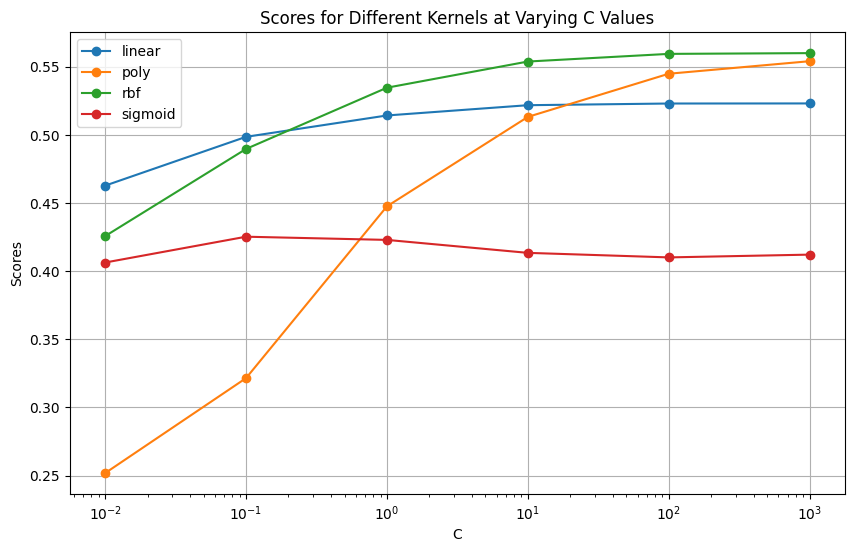

In [20]:
display_kernels_score_line(c_kernel_results, log_xaxis = True)

From these results, with the exception of the sigmoid kernel, performance tends to improve the higher the value of C is. The increase in accuracy tends to slow as C reaches higher values. The highest performing C values are from 10-1000.

There is a clear gap in performance between the sigmoid kernel and the other kernels, so it will not be used going forward. For fine-tuning, further C values will now be explored. These will be in the range 10-1250.


In [27]:
params = {'C': [10, 50, 100, 250, 500, 1000, 1250, 1500], 
            'kernel': ['linear', 'poly', 'rbf']}
params =  list(ParameterGrid(params)) 
params

[{'C': 10, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'poly'},
 {'C': 10, 'kernel': 'rbf'},
 {'C': 50, 'kernel': 'linear'},
 {'C': 50, 'kernel': 'poly'},
 {'C': 50, 'kernel': 'rbf'},
 {'C': 100, 'kernel': 'linear'},
 {'C': 100, 'kernel': 'poly'},
 {'C': 100, 'kernel': 'rbf'},
 {'C': 250, 'kernel': 'linear'},
 {'C': 250, 'kernel': 'poly'},
 {'C': 250, 'kernel': 'rbf'},
 {'C': 500, 'kernel': 'linear'},
 {'C': 500, 'kernel': 'poly'},
 {'C': 500, 'kernel': 'rbf'},
 {'C': 1000, 'kernel': 'linear'},
 {'C': 1000, 'kernel': 'poly'},
 {'C': 1000, 'kernel': 'rbf'},
 {'C': 1250, 'kernel': 'linear'},
 {'C': 1250, 'kernel': 'poly'},
 {'C': 1250, 'kernel': 'rbf'},
 {'C': 1500, 'kernel': 'linear'},
 {'C': 1500, 'kernel': 'poly'},
 {'C': 1500, 'kernel': 'rbf'}]

In [28]:
further_c_kernel_results = svc_model_cv_score(params)
further_c_kernel_results

[{'C': 10, 'kernel': 'linear', 'score': 0.5217901234567901},
 {'C': 10, 'kernel': 'poly', 'score': 0.5132098765432099},
 {'C': 10, 'kernel': 'rbf', 'score': 0.5538271604938272},
 {'C': 50, 'kernel': 'linear', 'score': 0.5228395061728395},
 {'C': 50, 'kernel': 'poly', 'score': 0.5379012345679012},
 {'C': 50, 'kernel': 'rbf', 'score': 0.5584567901234567},
 {'C': 100, 'kernel': 'linear', 'score': 0.5230246913580248},
 {'C': 100, 'kernel': 'poly', 'score': 0.5448765432098764},
 {'C': 100, 'kernel': 'rbf', 'score': 0.5594444444444445},
 {'C': 250, 'kernel': 'linear', 'score': 0.5228395061728395},
 {'C': 250, 'kernel': 'poly', 'score': 0.5509259259259258},
 {'C': 250, 'kernel': 'rbf', 'score': 0.5620370370370371},
 {'C': 500, 'kernel': 'linear', 'score': 0.5229012345679013},
 {'C': 500, 'kernel': 'poly', 'score': 0.5512962962962964},
 {'C': 500, 'kernel': 'rbf', 'score': 0.5614814814814814},
 {'C': 1000, 'kernel': 'linear', 'score': 0.5230864197530865},
 {'C': 1000, 'kernel': 'poly', 'score'

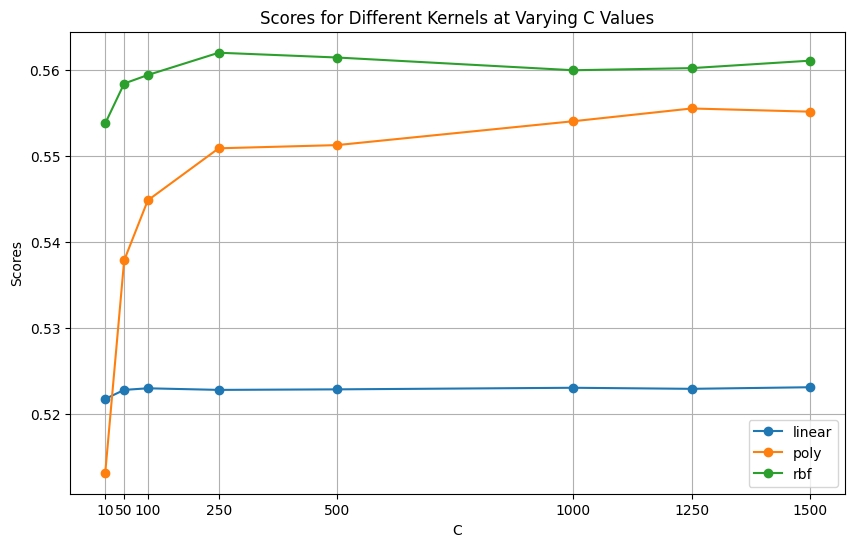

In [22]:
display_kernels_score_line(further_c_kernel_results)

From these results, it is clear that the rbf and poly kernels are consistently providing the highest accuracy of all kernels. Therefore, the linear kernel will not be explored any further, and removed.

C values between 100-500 will be explored further, as this is the range of C-values the best performance was achieved in.


In [30]:
params = {'C': [100, 150, 200, 250, 300, 350, 400, 450, 500], 
            'kernel': ['rbf', 'poly']
            }
params = list(ParameterGrid(params)) 
params

[{'C': 100, 'kernel': 'rbf'},
 {'C': 100, 'kernel': 'poly'},
 {'C': 150, 'kernel': 'rbf'},
 {'C': 150, 'kernel': 'poly'},
 {'C': 200, 'kernel': 'rbf'},
 {'C': 200, 'kernel': 'poly'},
 {'C': 250, 'kernel': 'rbf'},
 {'C': 250, 'kernel': 'poly'},
 {'C': 300, 'kernel': 'rbf'},
 {'C': 300, 'kernel': 'poly'},
 {'C': 350, 'kernel': 'rbf'},
 {'C': 350, 'kernel': 'poly'},
 {'C': 400, 'kernel': 'rbf'},
 {'C': 400, 'kernel': 'poly'},
 {'C': 450, 'kernel': 'rbf'},
 {'C': 450, 'kernel': 'poly'},
 {'C': 500, 'kernel': 'rbf'},
 {'C': 500, 'kernel': 'poly'}]

In [31]:
rbf_poly_c_results = svc_model_cv_score(params)
rbf_poly_c_results

[{'C': 100, 'kernel': 'rbf', 'score': 0.5594444444444445},
 {'C': 100, 'kernel': 'poly', 'score': 0.5448765432098764},
 {'C': 150, 'kernel': 'rbf', 'score': 0.5609259259259259},
 {'C': 150, 'kernel': 'poly', 'score': 0.548641975308642},
 {'C': 200, 'kernel': 'rbf', 'score': 0.5604320987654321},
 {'C': 200, 'kernel': 'poly', 'score': 0.5497530864197531},
 {'C': 250, 'kernel': 'rbf', 'score': 0.5620370370370371},
 {'C': 250, 'kernel': 'poly', 'score': 0.5509259259259258},
 {'C': 300, 'kernel': 'rbf', 'score': 0.5627777777777777},
 {'C': 300, 'kernel': 'poly', 'score': 0.5509876543209877},
 {'C': 350, 'kernel': 'rbf', 'score': 0.5626543209876543},
 {'C': 350, 'kernel': 'poly', 'score': 0.5508024691358024},
 {'C': 400, 'kernel': 'rbf', 'score': 0.5620987654320988},
 {'C': 400, 'kernel': 'poly', 'score': 0.5510493827160493},
 {'C': 450, 'kernel': 'rbf', 'score': 0.5619135802469135},
 {'C': 450, 'kernel': 'poly', 'score': 0.5509876543209876},
 {'C': 500, 'kernel': 'rbf', 'score': 0.561481481

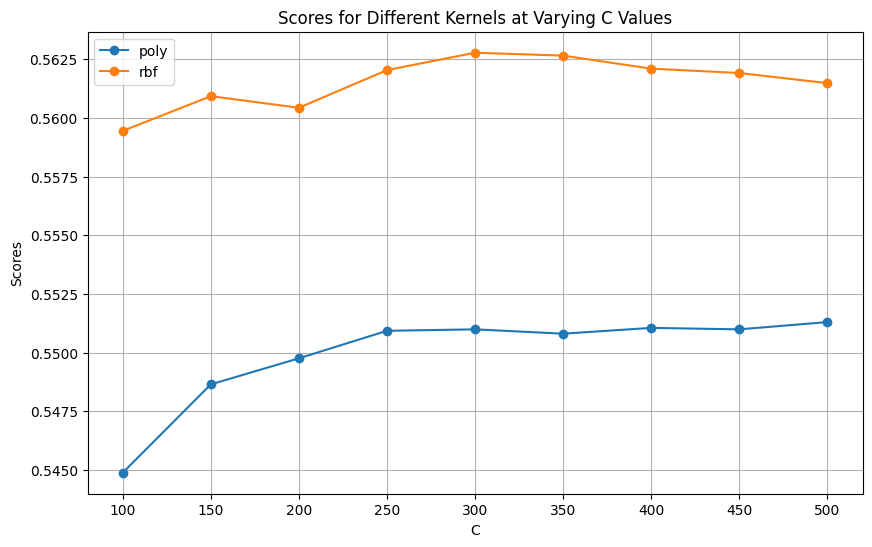

In [24]:
display_kernels_score_line(rbf_poly_c_results)

Based on these results:
* The rbf kernel is the best performing kernel, with consistently higher scores than the poly kernel.
* There has been an increase in performance due to this fine-tuning, but the increases are starting to become minimal.

The next set of C-values explored will be the last values to be explored, with the best performing value kept in further exploration. While more fine-tuning could be performed, the increases in performance are very minimal at this point. Therefore, it is not worth pursuing further fine-tuning of C values as there are other hyperparameters to be explored. 

The range of values to be inspected is 250-400 with the rfb kernel, as this is the range the best performing model (C = 300) fell in.

In [33]:
params = {'C': [250, 275, 300, 325, 350, 375, 400], 
            'kernel': ['rbf']
            }
params = list(ParameterGrid(params)) 
params

[{'C': 250, 'kernel': 'rbf'},
 {'C': 275, 'kernel': 'rbf'},
 {'C': 300, 'kernel': 'rbf'},
 {'C': 325, 'kernel': 'rbf'},
 {'C': 350, 'kernel': 'rbf'},
 {'C': 375, 'kernel': 'rbf'},
 {'C': 400, 'kernel': 'rbf'}]

In [34]:
final_c_results = svc_model_cv_score(params)
final_c_results

[{'C': 250, 'kernel': 'rbf', 'score': 0.5620370370370371},
 {'C': 275, 'kernel': 'rbf', 'score': 0.5625925925925926},
 {'C': 300, 'kernel': 'rbf', 'score': 0.5627777777777777},
 {'C': 325, 'kernel': 'rbf', 'score': 0.5628395061728395},
 {'C': 350, 'kernel': 'rbf', 'score': 0.5626543209876543},
 {'C': 375, 'kernel': 'rbf', 'score': 0.5623456790123458},
 {'C': 400, 'kernel': 'rbf', 'score': 0.5620987654320988}]

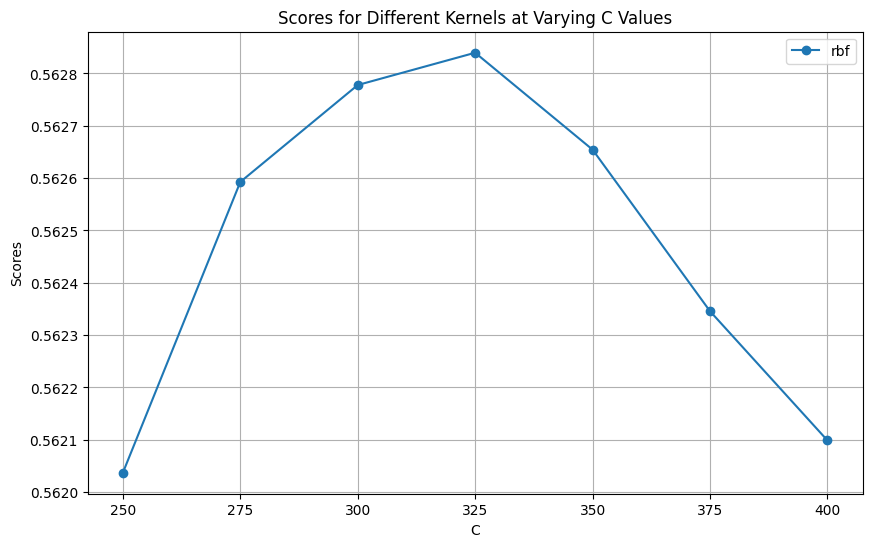

In [26]:
display_kernels_score_line(final_c_results)

The best performing value is C = 325.

### <a id='toc1_4_2_'></a>[Exploring class weights and shrinking](#toc0_)

Next balancing the class weights as well as the shrinking heuristic will be explored. 

Class Weights:
* The values to be explored are "balanced" and "None". Balancing the class weights involves adjusting them so that each class in the dataset has equal importance during model training. This is a useful adjustment when there are class imbalances, as observed when evaluating the base model.

Shrinking:
* This is a heuristic that attempts to improve optimisation of the SVM.

The expectation is for the model to perform better, as it should have improved optimisation as well as being better able to differentiate between classes. 

In [36]:
params = {'C': [325], 
            'kernel': ['rbf'],
            'class_weight': ['balanced', None],
            'shrinking': [True, False]}
params = list(ParameterGrid(params)) 
params

[{'C': 325, 'class_weight': 'balanced', 'kernel': 'rbf', 'shrinking': True},
 {'C': 325, 'class_weight': 'balanced', 'kernel': 'rbf', 'shrinking': False},
 {'C': 325, 'class_weight': None, 'kernel': 'rbf', 'shrinking': True},
 {'C': 325, 'class_weight': None, 'kernel': 'rbf', 'shrinking': False}]

In [37]:
weights_shrinking_results = svc_model_cv_score(params)
weights_shrinking_results

[{'C': 325,
  'class_weight': 'balanced',
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5578395061728395},
 {'C': 325,
  'class_weight': 'balanced',
  'kernel': 'rbf',
  'shrinking': False,
  'score': 0.5578395061728395},
 {'C': 325,
  'class_weight': None,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5628395061728395},
 {'C': 325,
  'class_weight': None,
  'kernel': 'rbf',
  'shrinking': False,
  'score': 0.562716049382716}]

In [38]:
def display_bar_compare(results: list, comparing: str | list[str]) -> None:
    """
    Display a bar plot comparing scores for different parameter combinations.

    Args:
        results (list): A list of dictionaries containing parameter combinations and scores.
        comparing (str | list[str]): A single parameter or a list of parameters to compare.

    Raises:
        ValueError: If comparing is neither a string nor a list.

    Returns:
        None
    """
    # Convert to a format suitable for plotting
    x_labels = []
    for param in results:
        # Handle single comparison
        if isinstance(comparing, str):
            x_label = f"{comparing}={param[comparing]}"
            x_labels.append(x_label)
        # Handle multiple comparisons
        elif isinstance(comparing, list):
            x_label = ', '.join([f"{comp}={param[comp]}" for comp in comparing])
            x_labels.append(x_label)
        else:
            raise ValueError("comparing must be either a string or a list")
    scores = [param['score'] for param in results]

    # Sort parameter combinations by score
    sorted_indices = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
    sorted_x_labels = [x_labels[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    # Find the best-performing parameter combination
    best_score = sorted_scores[0]
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_x_labels, sorted_scores, color='skyblue')
    bars[0].set_color('orange')  # Highlight the bar for the best-performing combination
    plt.xlabel('Score')
    plt.title('Cross-validation Scores for Different Parameter Combinations')
    plt.gca().invert_yaxis()  # Invert y-axis to have highest score at the top

    # Annotate best score
    plt.text(best_score + 0.01, 0, f'Score: {best_score:.4f}', va='center', color='black')

    plt.show()

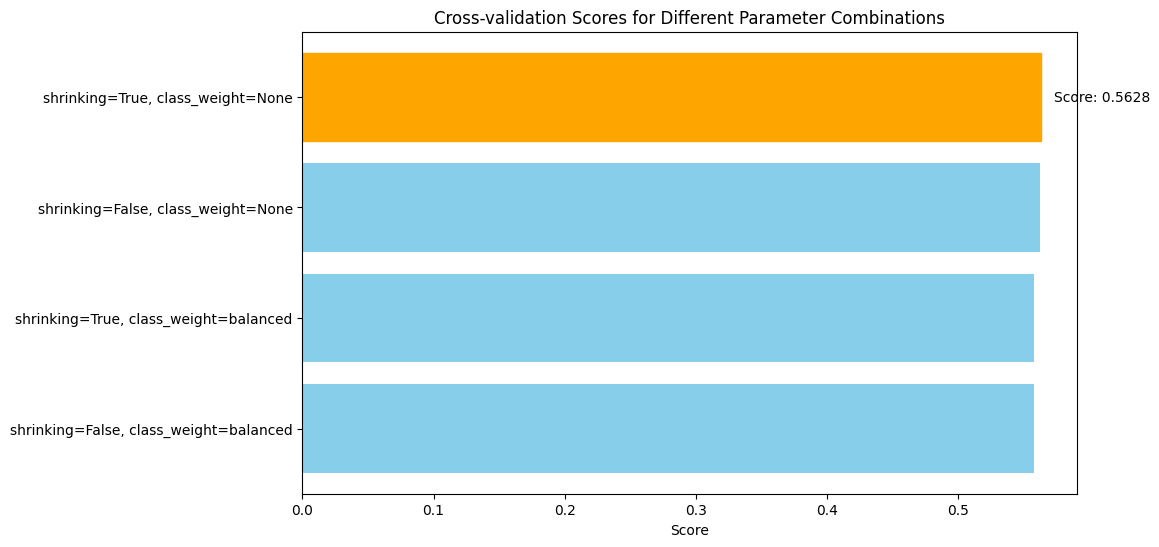

In [39]:
display_bar_compare(weights_shrinking_results, ['shrinking','class_weight'])

From these results:
* Balancing class weights results in a slightly worse performance, different from expectations.
* Enabling the shrinking heuristic has lead to a minor increase in performance, in line with expectations.

### <a id='toc1_4_3_'></a>[Exploring Gamma](#toc0_)

The gamma hyperparameter will be explored. Gamma is a value that effects the kernel coefficient in kernels like the one used here, rbf.

In [49]:
params = {'C': [325], 
            'kernel': ['rbf'], 
            'class_weight': [None],
            'shrinking': [True],
            'gamma': [0.01, 0.1, 1.0, 10.0, 'auto', 'scale']}
params =  list(ParameterGrid(params)) 
params

[{'C': 325,
  'class_weight': None,
  'gamma': 0.01,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.1,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 1.0,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 10.0,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 'auto',
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': 'rbf',
  'shrinking': True}]

In [50]:
gamma_results = svc_model_cv_score(params)
gamma_results

[{'C': 325,
  'class_weight': None,
  'gamma': 0.01,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5495679012345679},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.1,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5630864197530865},
 {'C': 325,
  'class_weight': None,
  'gamma': 1.0,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5237037037037038},
 {'C': 325,
  'class_weight': None,
  'gamma': 10.0,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.4366666666666667},
 {'C': 325,
  'class_weight': None,
  'gamma': 'auto',
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5630864197530865},
 {'C': 325,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5628395061728395}]

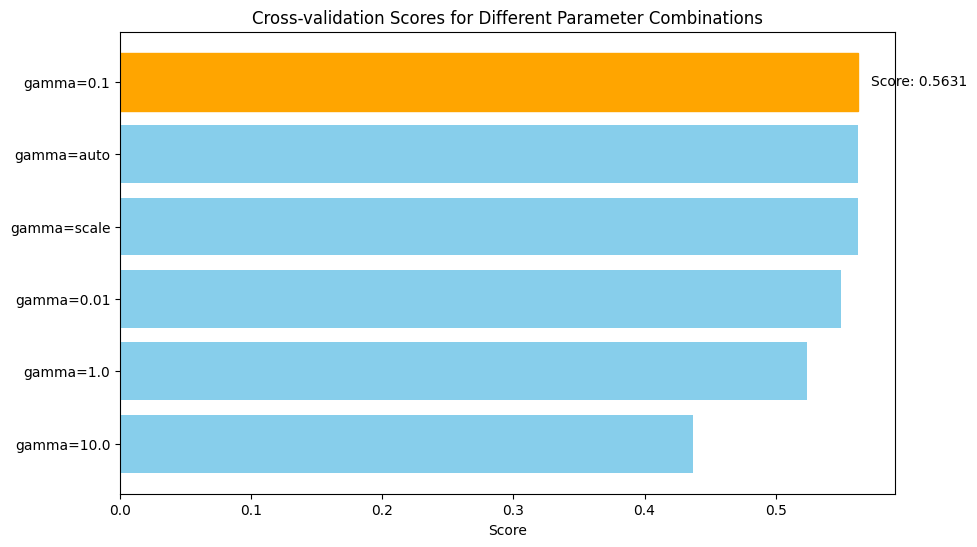

In [55]:
display_bar_compare(gamma_results, 'gamma')

As shown, the value 0.1 is the highest performing value. For fine-tuning, values around 0.1 for gamma will now be explored. There may be values close to 0.1 that provide a further increase in performance.

In [57]:
params = {'C': [325], 
            'kernel': ['rbf'], 
            'class_weight': [None],
            'shrinking': [True],
            'gamma': [0.05, 0.1, 0.15, 0.20]}
params =  list(ParameterGrid(params)) 
params

[{'C': 325,
  'class_weight': None,
  'gamma': 0.05,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.1,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.15,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.2,
  'kernel': 'rbf',
  'shrinking': True}]

In [58]:
further_gamma_results = svc_model_cv_score(params)
further_gamma_results

[{'C': 325,
  'class_weight': None,
  'gamma': 0.05,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5590123456790124},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.1,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5630864197530865},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.15,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5605555555555555},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.2,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5590123456790124}]

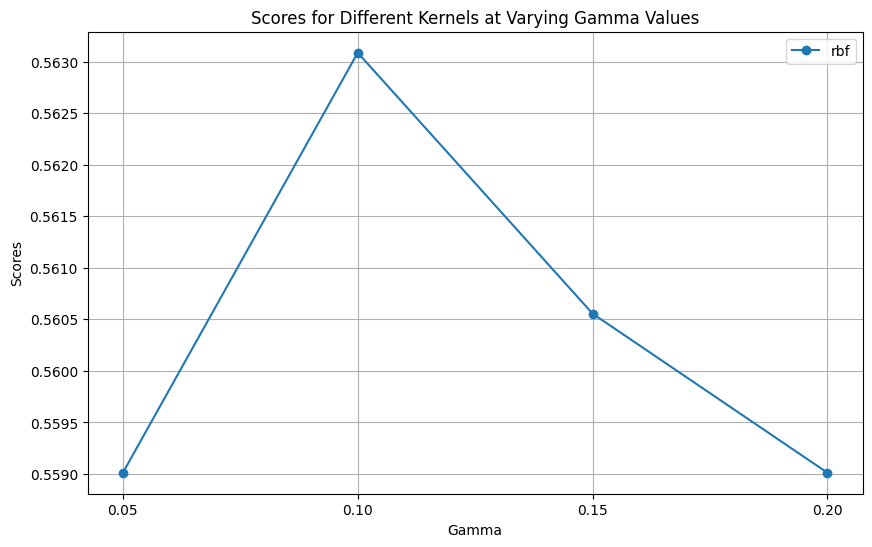

In [28]:
display_kernels_score_line(further_gamma_results, comparison='gamma')

Values between 0.05 and 0.15 will be explored further for further fine-tuning purposes.

In [117]:
params = {'C': [325], 
            'kernel': ['rbf'], 
            'class_weight': [None],
            'shrinking': [True],
            'gamma': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]}
params =  list(ParameterGrid(params)) 
params

[{'C': 325,
  'class_weight': None,
  'gamma': 0.05,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.06,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.07,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.08,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.09,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.1,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.11,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.12,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.13,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.14,
  'kernel': 'rbf',
  'shrinking': True},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.15,
  'kerne

In [118]:
final_gamma_results = svc_model_cv_score(params)
final_gamma_results

[{'C': 325,
  'class_weight': None,
  'gamma': 0.05,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5590123456790124},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.06,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5598148148148148},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.07,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5606172839506173},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.08,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5601851851851852},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.09,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.562037037037037},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.1,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5630864197530865},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.11,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5624074074074075},
 {'C': 325,
  'class_weight': None,
  'gamma': 0.12,
  'kernel': 'rbf',
  'shrinking': True,
  'score': 0.5610493827160493},
 {

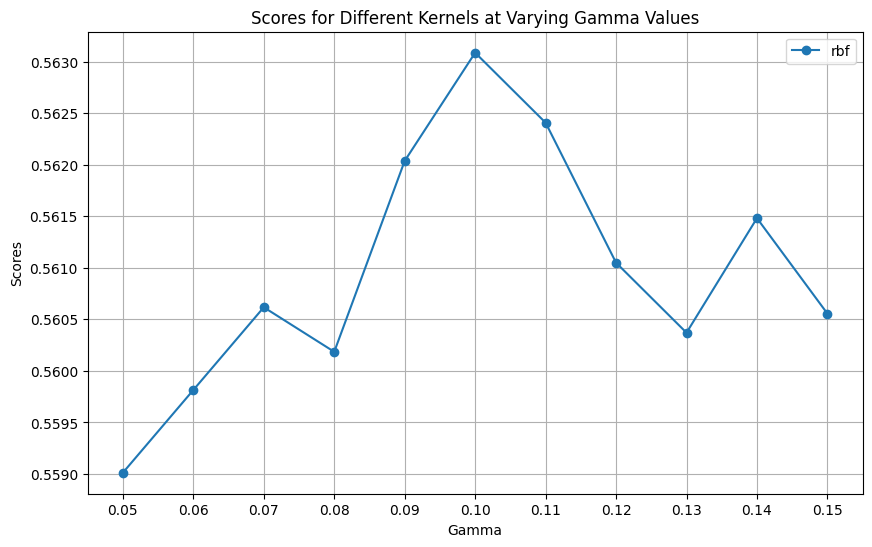

In [30]:
display_kernels_score_line(final_gamma_results, comparison='gamma')

The highest performing gamma value is 0.1, so it will be the kept value. Performance has improved slightly since the beginning of the gamma exploration. This has kept in line with expectations.

No further hyperparameter exploration will be performed, due to time constraints. The combination of parameters reached from the above exploration have an improved but still somewhat low cross-validation score. Further explorations could involve:
* Further C values 
* Further gamma values
* Exploring the LinearSVC classifier provided by sklearn
* Exploring the tol hyperparameter
* Comparing created models using further evaluation metrics, like F1-Score

There has been an increase in the cross-validation score as a result of this hyperparameter exploration. Now, the final model will be evaluated further. 

In [120]:
final_results = final_gamma_results

In [121]:
best_params = max(final_results, key=lambda x: x['score'])
best_params

{'C': 325,
 'class_weight': None,
 'gamma': 0.1,
 'kernel': 'rbf',
 'shrinking': True,
 'score': 0.5630864197530865}

In [122]:
best_params_cv_score = best_params.pop('score')
best_params_cv_score

0.5630864197530865

In [123]:
#Train final model with best hyperparameters
best_model = SVC(**best_params)
best_params['score'] = best_params_cv_score
best_model.fit(features_train, targets_train)

SVC(C=325, gamma=0.1)

In [124]:
model_filename = 'task1_svc.pkl'
# Save the model to a file using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

In [125]:
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
final_svc = loaded_model

## <a id='toc1_5_'></a>[Evaluating the Chosen Model's Performance](#toc0_)

In [126]:
predict = final_svc.predict(features_test)

In [134]:
print("Classification Report:")
print(classification_report(targets_test, predict))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.64      0.55       613
         1.0       0.50      0.75      0.60       605
         2.0       0.43      0.46      0.45       628
         3.0       0.35      0.27      0.30       499
         4.0       0.50      0.47      0.49       507
         5.0       0.32      0.20      0.24       409
         6.0       0.42      0.36      0.39       481
         7.0       0.84      0.85      0.84       583
         8.0       0.53      0.35      0.42       511
         9.0       0.91      0.88      0.89       564

    accuracy                           0.54      5400
   macro avg       0.53      0.52      0.52      5400
weighted avg       0.54      0.54      0.53      5400



Based on these results, it can be said:
* The precision, recall, and F1-score vary across different classes, this suggests the model is performing differently for each class. The model is better at correctly classifying certain classes than it is others.
  * The classes with higher precision, recall, and F1-score values are classes 1, 7, and 9. 
* The classes with lower precision, recall, and F1-score values are classes 3 and 5.
* The accuracy of the model is 54.41%. This is relatively low.
* Overall, while the model performs reasonably well for some classes, there is room for improvement, especially for classes with lower precision, recall, and F1-score values. Further hyperparameter exploration and fine-tuning may be required to improve the model's performance. However, it is also possible that support vector machines are not suited to this dataset. Due to the increase in performance, the exploration of hyperparameters can be considered a success.

Next, some visualisations of performance will be displayed. These are a confusion matrix, a precision-recall curve and a ROC curve.

A confusion matrix is a table that is often used to describe the performance of a classification model. It assists in visualisation of the performance of a model. Elements on the diagonal represent correct predictions for each class, while off-diagonal elements represent misclassifications.

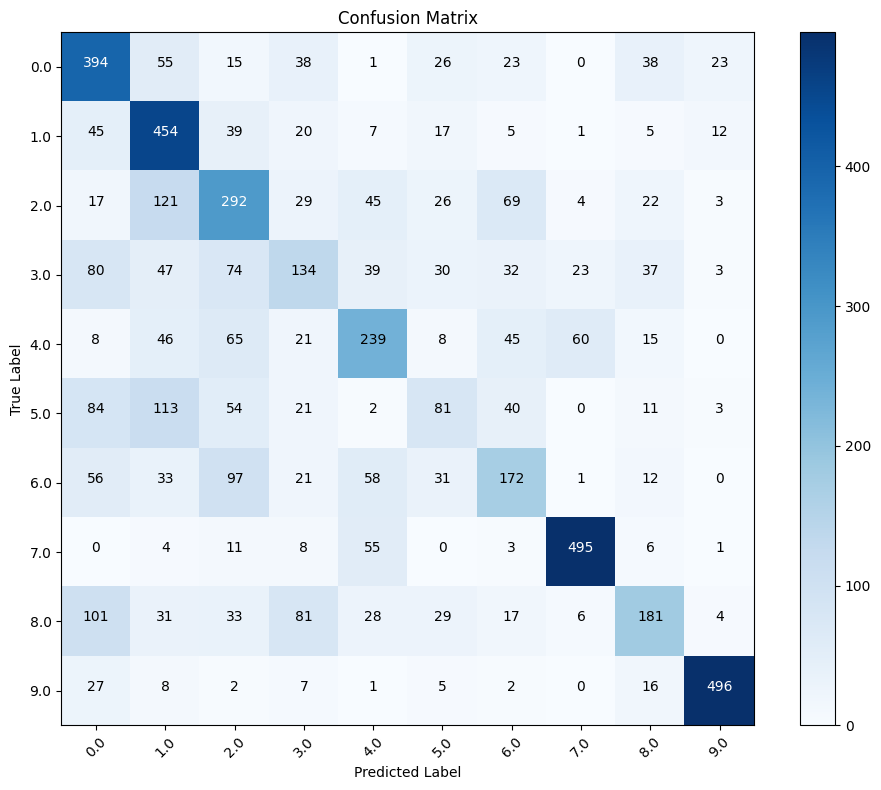

In [128]:
# Create the CM

# Get the unique class labels
classes = np.unique(targets_test)

# Confusion Matrix
cm = confusion_matrix(targets_test, predict)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

A precision-recall curve is a plot of the precision and recall for different classes in a classification model. This visualises the trade-off between precision and recall, indicating the model's performance. A higher area under the precision-recall curve (AUC-PR) indicates better overall performance of the model.

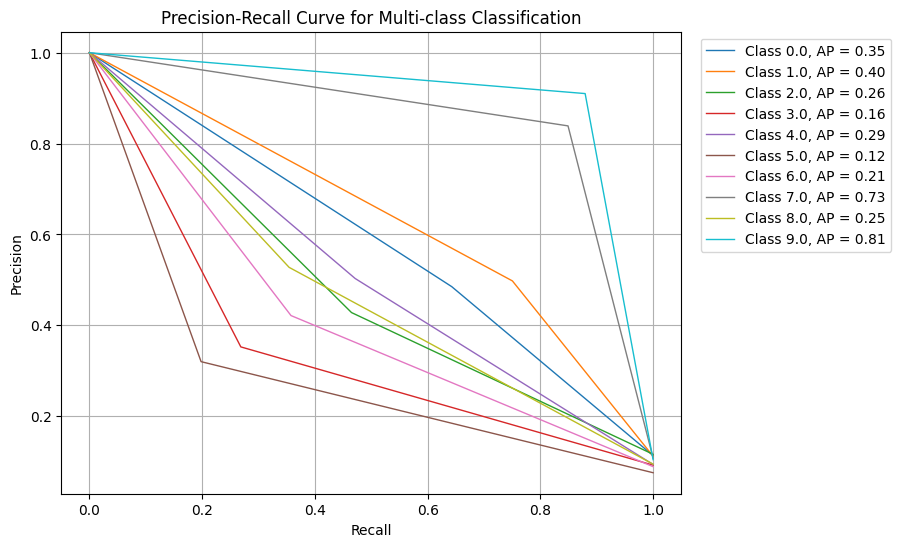

In [129]:
# Create p-r curve
classes = np.unique(targets_test)
# Initialise arrays to store precision and recall values for each class
precision = dict()
recall = dict()
average_precision = dict()  # Store average precision scores for each class

# Calculate precision and recall for each class
for cls in classes:
    targets_bin = np.where(targets_test == cls, 1, 0)
    targets_pred_bin = np.where(predict == cls, 1, 0)
    
    # Calculate precision, recall, and average precision
    precision[cls], recall[cls], _ = precision_recall_curve(targets_bin, targets_pred_bin)
    average_precision[cls] = average_precision_score(targets_bin, targets_pred_bin)

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for cls in classes:
    plt.plot(recall[cls], precision[cls], lw=1, label=f'Class {cls}, AP = {average_precision[cls]:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class Classification')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.grid(True)
plt.show()

The ROC curve is a plot that shows the true positive rate against the false positive rate for different classes. A higher AUC-ROC value indicates better overall performance of the model in distinguishing between the two classes.

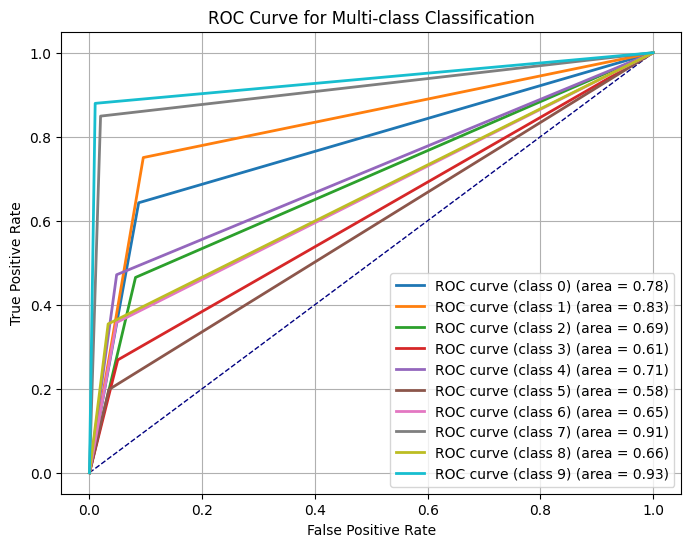

ROC Curve: The Receiver Operating Characteristic (ROC) curve illustrates the performance of a binary classification model across different thresholds. Here, we use micro-averaging to extend the ROC curve to multi-class classification, which provides an aggregate curve.


In [137]:
# Create the ROC curve

# Binarise the target variables
targets_bin = label_binarize(targets_test, classes=np.unique(targets_test))
targets_pred_bin = label_binarize(predict, classes=np.unique(targets_test))

# Determine the number of classes
n_classes = targets_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], targets_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(targets_bin.ravel(), targets_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='navy', lw = 1, linestyle='--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw = 2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend()
plt.grid(True)
plt.show()

## <a id='toc1_6_'></a>[Conclusion](#toc0_)

After applying appropriate pre-processing techniques, as well as hyperparameter exploration with comparisons of hyperparameter combinations using CV scores, a support vector classifier was created. This classifier outperforms the base model provided on sci-kit learn (CV score of 0.534 versus 0.563). Results have been visualised and discussed. Despite an improvement in performance, the resulting model arguably has a low level of performance. Suggestions for further hyperparameter exploration were provided.  

# <a id='toc2_'></a>[Markdown Question](#toc0_)

_The difficulty in using pearson correlation method for feature selection is determining the appropriate number of
features to select. The method described in the module to automatically choose the appropriate number of features will be computationally very expensive when the number of features is high. Describe an alternative method to reduce the computational complexity of the method discussed in class for datasets with large number of features. **Describe the method. No need to write the program.** (150 words)_



## <a id='toc2_1_'></a>[Answer](#toc0_)

One alternative method would be to deploy Principal Component Analysis (PCA). PCA is an unsupervised technique that transforms the original features into a new set of features called principal components. These principal components are ordered by the amount of variance they explain in the data, with the first component containing the most variance, followed by others with less.
In the wrapper method with Pearson correlation, PCA can be utilised as a preprocessing step before computing correlations. By reducing the dimensionality of the feature space, PCA decreases the number of features, reducing the computational cost of calculating Person correlation.

The steps for this would therefore be as follows:
* Standardise the Data.
* Use PCA tool of choice to reduce the number of features to a desired number. 
* Compute the performance of the model when using increasing numbers of the new features, stopping when performance stops improving.
